## Importing Dataset from Kaggle

In [ ]:
! mkdir -p ~/.kaggle

In [ ]:
! cp  ./drive/MyDrive/Colab_Notebooks/cnn_project/kaggle/kaggle.json ~/.kaggle/


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
! kaggle datasets download -d samuelcortinhas/cats-and-dogs-image-classification -p ./drive/MyDrive/Colab_Notebooks/cnn_project/datasets/

Dataset URL: https://www.kaggle.com/datasets/samuelcortinhas/cats-and-dogs-image-classification
License(s): CC0-1.0
 92% 59.0M/64.4M [00:00<00:00, 97.4MB/s]
100% 64.4M/64.4M [00:00<00:00, 90.7MB/s]


In [22]:
dir_path = './drive/MyDrive/Colab_Notebooks/cnn_project/datasets'

In [ ]:
# Unzip data in my google Drive
import zipfile

zip_ref = zipfile.ZipFile(dir_path + '/cats-and-dogs-image-classification.zip', 'r')
zip_ref.extractall(dir_path + '/cats-and-dogs')
zip_ref.close()


In [1]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


## Preprocessing Data

In [86]:
# Libraries
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [87]:
dir_path = './drive/MyDrive/Colab_Notebooks/cnn_project/datasets'

In [88]:
# Creating data generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = dir_path + '/cats-and-dogs/train',  # Directory to train data
    labels = 'inferred',                            # Keras indicates labels based on folders name
    label_mode = 'int',                             # indicats the labels are intiger
    batch_size = 2,                                 # Batch size is defined 2
    image_size = (150, 150),                        # change the image size in (150,150)
    shuffle = True                                  # randomly selection for better generalizing
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = dir_path + '/cats-and-dogs/validate',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 2,
    image_size = (150, 150),
    shuffle = True
)
class_names_train = train_ds.class_names
class_names_validation = validation_ds.class_names

print(class_names_train)
print(class_names_validation)


Found 1000 files belonging to 2 classes.
Found 260 files belonging to 2 classes.
['cat', 'dog']
['cat', 'dog']


In [90]:
from PIL import Image
import os

img_path = "./drive/MyDrive/Colab_Notebooks/cnn_project/datasets/cats-and-dogs/train/cat/0 (1).png"
img = Image.open(img_path)

print("Original size:", img.size)  # Output: (width, height)


Original size: (224, 224)


In [91]:
# Data Augmentation

data_augmentation = tf.keras.Sequential([
    # tf.keras.layers.RandomFlip("horizontal"),    # Flipping data horizentaly
    tf.keras.layers.RandomRotation(0.05),        # Rotate data 5%
    tf.keras.layers.RandomZoom(0.05),            # Zoom data 5%
])


# Apply Augmentation Randomly to 50% of Images

def augmentation(image, label):
    return tf.cond(
        tf.random.uniform(()) > 0.5,             # just apply on 50%
        lambda: (data_augmentation(image, training=True), label),
        lambda: (image, label)
    )

# Apply augmentation only to train dataset
train_ds = train_ds.map(augmentation)


In [92]:
# Normalize
def process(image, label):
    image = tf.cast(image/255.0, tf.float32)
    # label = tf.cast(label, tf.float32)
    return image, label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)


In [93]:
# Allows TensorFlow to automatically choose the best buffer size to improve performanc
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


In [94]:
# Show the data type
for image_batch, label_batch in train_ds.take(1):
    print(f"Image batch dtype: {image_batch.dtype}")
    print(f"Label batch dtype: {label_batch.dtype}")


Image batch dtype: <dtype: 'float32'>
Label batch dtype: <dtype: 'int32'>


In [95]:
# show the data size
for image_batch, label_batch in train_ds.take(1):
    print("Sample image batch shape:", image_batch.shape)
    print("Sample label batch shape:", label_batch.shape)

Sample image batch shape: (2, 150, 150, 3)
Sample label batch shape: (2,)


# **Creat and Train the Model**

In [96]:
model = keras.Sequential()

model.add(keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(150,150,3))) # Stride = 1
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Flatten())  # Transfer all matrix or tensors into a vector (1 D)

model.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(1, activation='sigmoid'))


In [97]:
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 150, 150, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 150, 150, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 75, 75, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 75, 75, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 75, 75, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 37, 37, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 37, 37, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │       1,327,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,351,265 (5.15 MB)

 Trainable params: 1,351,041 (5.15 MB)

 Non-trainable params: 224 (896.00 B)

In [98]:
early_stop = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)



In [99]:
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy',metrics=['accuracy'])


In [100]:
history = model.fit(train_ds, validation_data=validation_ds, epochs=50, callbacks=[early_stop])


Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 48s 90ms/step - accuracy: 0.8990 - loss: 0.3875 - val_accuracy: 0.9615 - val_loss: 0.1872
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 83s 93ms/step - accuracy: 0.9755 - loss: 0.1908 - val_accuracy: 0.9769 - val_loss: 0.1754
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 93ms/step - accuracy: 0.9873 - loss: 0.1659 - val_accuracy: 0.9731 - val_loss: 0.2189
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 81s 92ms/step - accuracy: 0.9723 - loss: 0.2000 - val_accuracy: 0.9846 - val_loss: 0.2042
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 93ms/step - accuracy: 0.9933 - loss: 0.1427 - val_accuracy: 0.9731 - val_loss: 0.2163
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 48s 95ms/step - accuracy: 0.9901 - loss: 0.1613 - val_accuracy: 0.9808 - val_loss: 0.1578
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 92s 115ms/step - accuracy: 0.9977 - loss: 0.1284 - val_accuracy: 0.9692 - val_loss: 0.2635
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 62s 123ms/step - accuracy: 0.9894 - loss: 0.1463 

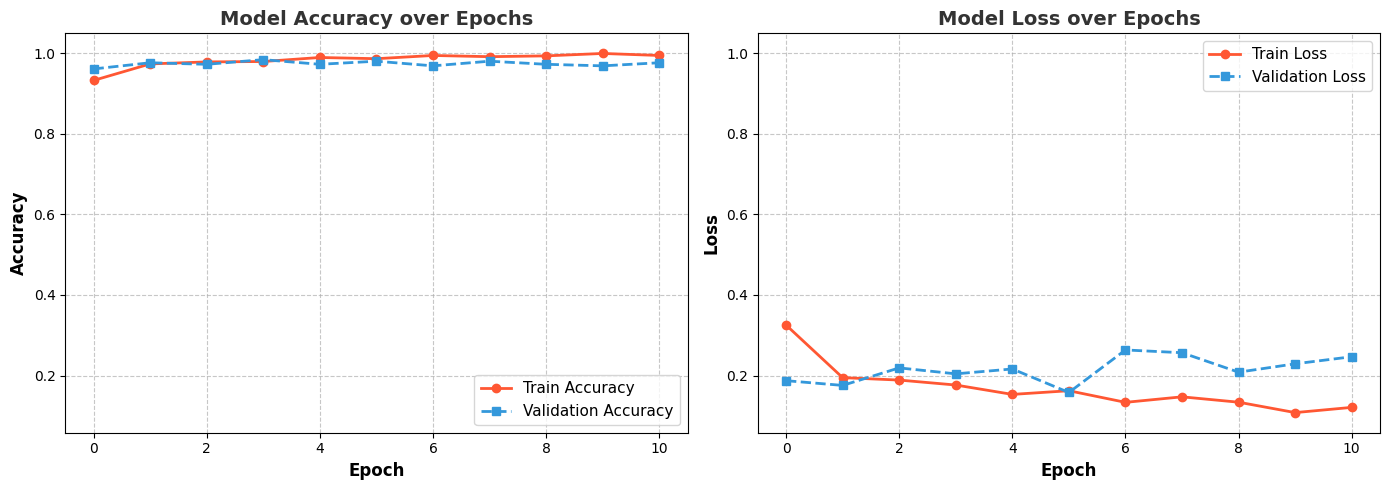

In [101]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Extract min/max values for consistent scaling
acc_min = min(min(history.history['accuracy']), min(history.history['val_accuracy']))
acc_max = max(max(history.history['accuracy']), max(history.history['val_accuracy']))
loss_min = min(min(history.history['loss']), min(history.history['val_loss']))
loss_max = max(max(history.history['loss']), max(history.history['val_loss']))

# Set y-limits with some padding
y_acc_min, y_acc_max = acc_min - 0.05, acc_max + 0.05  # Add padding for better visibility
y_loss_min, y_loss_max = loss_min - 0.05, loss_max + 0.05

# Ensure both graphs have the same scale range
common_min = min(y_acc_min, y_loss_min)
common_max = max(y_acc_max, y_loss_max)

# Plot Accuracy
axes[0].plot(history.history['accuracy'], color='#FF5733', marker='o', linestyle='-', linewidth=2, markersize=6, label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], color='#3498DB', marker='s', linestyle='--', linewidth=2, markersize=6, label='Validation Accuracy')
axes[0].set_title("Model Accuracy over Epochs", fontsize=14, fontweight="bold", color="#333")
axes[0].set_xlabel("Epoch", fontsize=12, fontweight="bold")
axes[0].set_ylabel("Accuracy", fontsize=12, fontweight="bold")
axes[0].legend(fontsize=11, loc="lower right")
axes[0].grid(True, linestyle="--", alpha=0.7)
axes[0].set_ylim(common_min, common_max)  # Set same scale

# Plot Loss
axes[1].plot(history.history['loss'], color='#FF5733', marker='o', linestyle='-', linewidth=2, markersize=6, label='Train Loss')
axes[1].plot(history.history['val_loss'], color='#3498DB', marker='s', linestyle='--', linewidth=2, markersize=6, label='Validation Loss')
axes[1].set_title("Model Loss over Epochs", fontsize=14, fontweight="bold", color="#333")
axes[1].set_xlabel("Epoch", fontsize=12, fontweight="bold")
axes[1].set_ylabel("Loss", fontsize=12, fontweight="bold")
axes[1].legend(fontsize=11, loc="upper right")
axes[1].grid(True, linestyle="--", alpha=0.7)
axes[1].set_ylim(common_min, common_max)  # Set same scale

plt.tight_layout()
plt.show()


## Test the Model

In [ ]:
#model = keras.models.load_model('./drive/MyDrive/Colab_Notebooks/cnn_project/cnn_model.h5')  # Replace with your filename


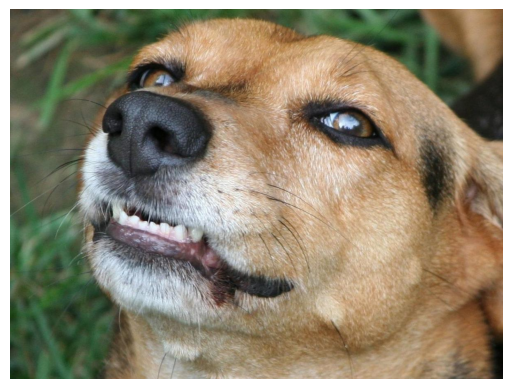

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Predicted class: dog (Confidence: 0.9999)


In [108]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
test_image = cv2.imread(dir_path + "/Testdata/dog_281.jpg")

# Convert BGR to RGB (since OpenCV loads images in BGR format)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(test_image)
plt.axis("off")  # Hide axes
plt.show()

# Resize the image to match model input size
test_image = cv2.resize(test_image, (150, 150))

# Normalize the image (same as training data)
test_image = test_image / 255.0  # Normalize to range [0,1]

# Reshape for model input
test_output = np.expand_dims(test_image, axis=0)  # Same as (1, 150, 150, 3)

# Make prediction
final_predict = model.predict(test_output)[0][0]  # Extract scalar value

# Apply threshold
threshold = 0.5
predicted_class = "dog" if final_predict >= threshold else "cat"


# Print prediction
print(f"Predicted class: {predicted_class} (Confidence: {final_predict:.4f})")


In [111]:
# Save to Google Drive
model.save("./drive/MyDrive/Colab_Notebooks/cnn_project/cnn_model.h5")
